# Product Sales Forecasting

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

## Loading the data

In [28]:
#put the dataset and this file in the same folder 
df = pd.read_csv("statsfinal.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors="coerce")
df

,Unnamed: 0,Date,Q-P1,Q-P2,Q-P3,Q-P4,S-P1,S-P2,S-P3,S-P4
0,0,2010-06-13,5422,3725,576,907,17187.74,23616.50,3121.92,6466.91
1,1,2010-06-14,7047,779,3578,1574,22338.99,4938.86,19392.76,11222.62
2,2,2010-06-15,1572,2082,595,1145,4983.24,13199.88,3224.90,8163.85
3,3,2010-06-16,5657,2399,3140,1672,17932.69,15209.66,17018.80,11921.36
4,4,2010-06-17,3668,3207,2184,708,11627.56,20332.38,11837.28,5048.04
...,...,...,...,...,...,...,...,...,...,...
4595,4595,2023-01-30,2476,3419,525,1359,7848.92,21676.46,2845.50,9689.67
4596,4596,2023-01-31,7446,841,4825,1311,23603.82,5331.94,26151.50,9347.43
4597,4597,2023-02-01,6289,3143,3588,474,19936.13,19926.62,19446.96,3379.62
4598,4598,2023-02-02,3122,1188,5899,517,9896.74,7531.92,31972.58,3686.21


In [3]:
df.info


<bound method DataFrame.info of       Unnamed: 0       Date  Q-P1  Q-P2  Q-P3  Q-P4      S-P1      S-P2  \
0              0 2010-06-13  5422  3725   576   907  17187.74  23616.50   
1              1 2010-06-14  7047   779  3578  1574  22338.99   4938.86   
2              2 2010-06-15  1572  2082   595  1145   4983.24  13199.88   
3              3 2010-06-16  5657  2399  3140  1672  17932.69  15209.66   
4              4 2010-06-17  3668  3207  2184   708  11627.56  20332.38   
...          ...        ...   ...   ...   ...   ...       ...       ...   
4595        4595 2023-01-30  2476  3419   525  1359   7848.92  21676.46   
4596        4596 2023-01-31  7446   841  4825  1311  23603.82   5331.94   
4597        4597 2023-02-01  6289  3143  3588   474  19936.13  19926.62   
4598        4598 2023-02-02  3122  1188  5899   517   9896.74   7531.92   
4599        4599 2023-02-03  1234  3854  2321   406   3911.78  24434.36   

          S-P3      S-P4  
0      3121.92   6466.91  
1     19392.7

## Preprocessing

In [4]:
df.isnull().sum()

Unnamed: 0     0
Date          26
Q-P1           0
Q-P2           0
Q-P3           0
Q-P4           0
S-P1           0
S-P2           0
S-P3           0
S-P4           0
dtype: int64

### Removing unwanted columns

In [5]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
df.columns.values

array(['Date', 'Q-P1', 'Q-P2', 'Q-P3', 'Q-P4', 'S-P1', 'S-P2', 'S-P3',
       'S-P4'], dtype=object)

### Renaming columns

In [7]:
df.columns = ['Date', 'Q1', 'Q2', 'Q3', 'Q4', 'S1', 'S2', 'S3', 'S4']

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

### Aggregating data with daily samples to yearly samples

In [8]:
df_yearly = df.resample('Y').sum()

df_yearly

,Q1,Q2,Q3,Q4,S1,S2,S3,S4
Date,,,,,,,,
2010-12-31,802353,429038,624624,219849,2543459.01,2720100.92,3385462.08,1567523.37
2011-12-31,1433066,747815,1150383,409762,4542819.22,4741147.10,6235075.86,2921603.06
2012-12-31,1505099,766875,1139098,415878,4771163.83,4861987.50,6173911.16,2965210.14
2013-12-31,1524821,752582,1110297,402313,4833682.57,4771369.88,6017809.74,2868491.69
2014-12-31,1562941,785457,1155979,401840,4954522.97,4979797.38,6265406.18,2865119.20
2015-12-31,1473098,762430,1104795,411392,4669720.66,4833806.20,5987988.90,2933224.96
2016-12-31,1507255,780007,1109885,406163,4777998.35,4945244.38,6015576.70,2895942.19
2017-12-31,1460109,802194,1156747,416542,4628545.53,5085909.96,6269568.74,2969944.46
2018-12-31,1522332,745633,1143638,396128,4825792.44,4727313.22,6198517.96,2824392.64


## EDA

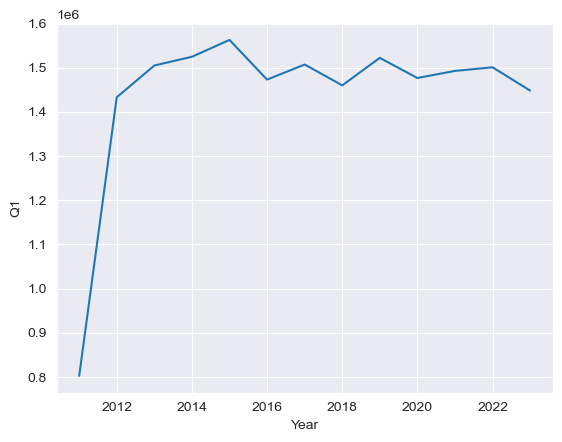

In [9]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="Q1")
plt.xlabel("Year")
plt.ylabel("Q1")
plt.show()

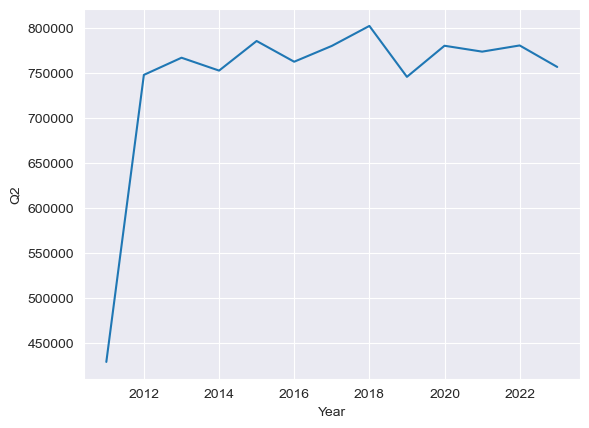

In [10]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="Q2")
plt.xlabel("Year")
plt.ylabel("Q2")
plt.show()

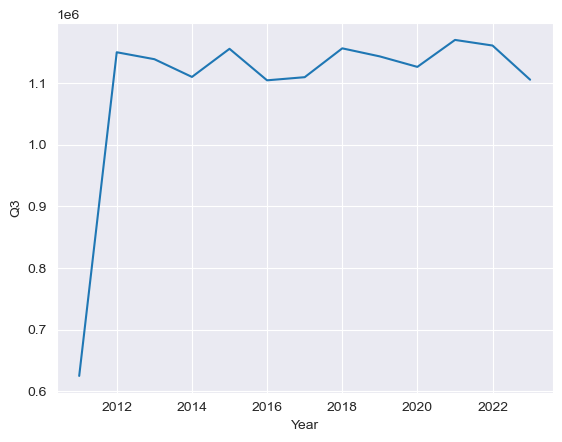

In [11]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="Q3")
plt.xlabel("Year")
plt.ylabel("Q3")
plt.show()

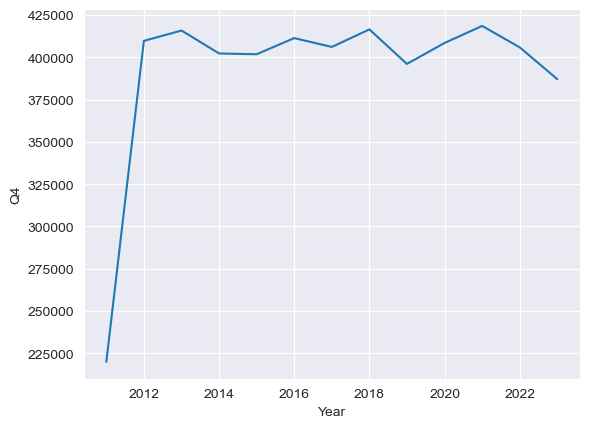

In [12]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="Q4")
plt.xlabel("Year")
plt.ylabel("Q4")
plt.show()

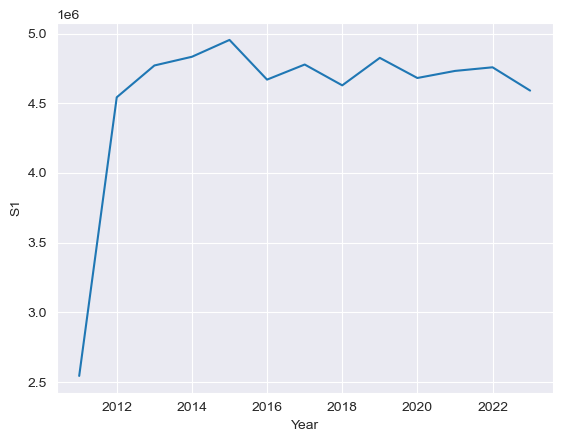

In [13]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="S1")
plt.xlabel("Year")
plt.ylabel("S1")
plt.show()

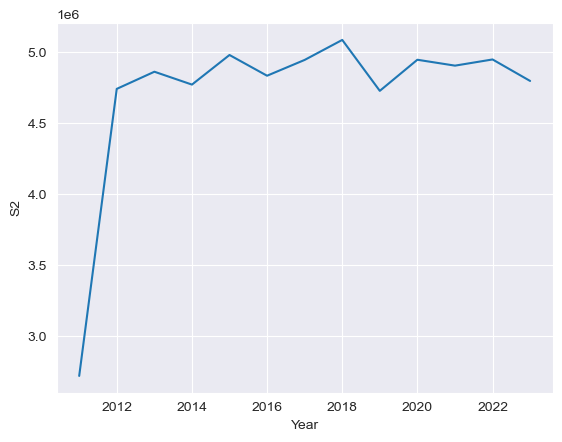

In [14]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="S2")
plt.xlabel("Year")
plt.ylabel("S2")
plt.show()

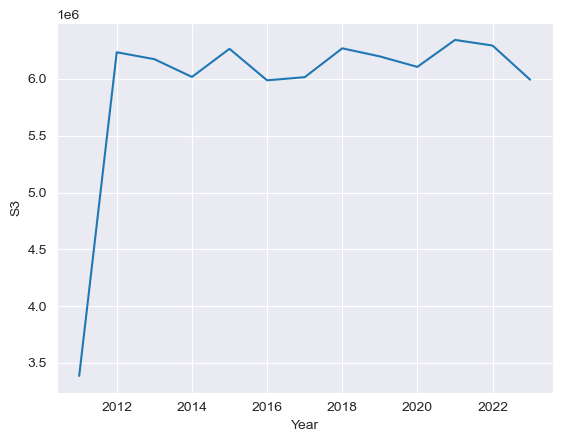

In [15]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="S3")
plt.xlabel("Year")
plt.ylabel("S3")
plt.show()

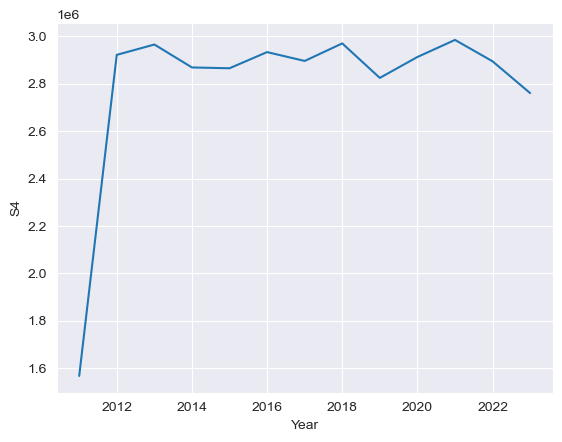

In [16]:
sns.lineplot(data=df_yearly.loc[:"2022", :], x=df_yearly.loc[:"2022", :].index.values,
             y="S4")
plt.xlabel("Year")
plt.ylabel("S4")
plt.show()

### Splitting for Train and Test

In [17]:
train = df_yearly.loc['2010-12-31':'2022-12-31', :]
test = df_yearly.loc['2023-12-31':'2023-12-31', :]

## Model Creation

In [18]:
product_column = 'Q2'  ## This will the column we are predicting

### Fit a SARIMAX model to training data

In [19]:
order = (1, 1, 1)
seasonal_order = (0, 0, 0, 12)  # Assumes annual seasonality

model = SARIMAX(train[product_column], order=order, seasonal_order=seasonal_order, freq="Y")
results = model.fit()

In [20]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                     Q2   No. Observations:                   13
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -182.550
Date:                Wed, 11 Oct 2023   AIC                            371.101
Time:                        11:11:44   BIC                            372.555
Sample:                    12-31-2010   HQIC                           370.562
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0873      0.020      4.269      0.000       0.047       0.127
ma.L1          0.6054      0.033     18.125      0.000       0.540       0.671
sigma2      3.135e+08   1.46e-11   2.15e+19      0.0

## Prediction

In [21]:
forecast = results.get_forecast(steps=3, dynamic=False)
forecast_values = forecast.predicted_mean

In [22]:
print(f"Predicted Values for {forecast_values.index.year[1]} : {forecast_values.values[1]}")

Predicted Values for 2024 : 722323.3350284399


In [23]:
df_yearly

,Q1,Q2,Q3,Q4,S1,S2,S3,S4
Date,,,,,,,,
2010-12-31,802353,429038,624624,219849,2543459.01,2720100.92,3385462.08,1567523.37
2011-12-31,1433066,747815,1150383,409762,4542819.22,4741147.10,6235075.86,2921603.06
2012-12-31,1505099,766875,1139098,415878,4771163.83,4861987.50,6173911.16,2965210.14
2013-12-31,1524821,752582,1110297,402313,4833682.57,4771369.88,6017809.74,2868491.69
2014-12-31,1562941,785457,1155979,401840,4954522.97,4979797.38,6265406.18,2865119.20
2015-12-31,1473098,762430,1104795,411392,4669720.66,4833806.20,5987988.90,2933224.96
2016-12-31,1507255,780007,1109885,406163,4777998.35,4945244.38,6015576.70,2895942.19
2017-12-31,1460109,802194,1156747,416542,4628545.53,5085909.96,6269568.74,2969944.46
2018-12-31,1522332,745633,1143638,396128,4825792.44,4727313.22,6198517.96,2824392.64


## Visualizing the prediction

### Joining both DataFrames

In [24]:
vis_data = df_yearly.loc[:"2022", ["Q2"]]
vis_data = vis_data.reset_index()
vis_data

,Date,Q2
0,2010-12-31,429038
1,2011-12-31,747815
2,2012-12-31,766875
3,2013-12-31,752582
4,2014-12-31,785457
5,2015-12-31,762430
6,2016-12-31,780007
7,2017-12-31,802194
8,2018-12-31,745633
9,2019-12-31,780174


In [25]:
new_df = pd.DataFrame({"Date": forecast_values.index.values[0:2], "Q2": forecast_values.values[0:2]})
new_df

,Date,Q2
0,2023-12-31,725078.428271
1,2024-12-31,722323.335028


In [26]:
final_df = pd.concat([vis_data, new_df]).set_index("Date")

### Result

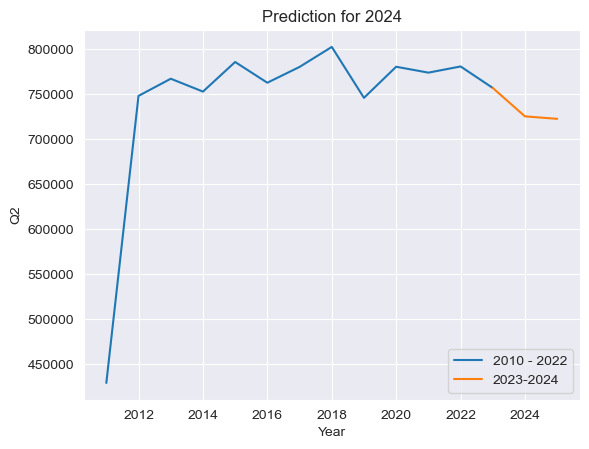

In [27]:
sns.lineplot(data=final_df.loc[:"2022", :], x=final_df.loc[:"2022", :].index.values, y="Q2", label="2010 - 2022")
sns.lineplot(data=final_df.loc["2022":, :], x=final_df.loc["2022":, :].index.values, y="Q2", label="2023-2024")
plt.title("Prediction for 2024")
plt.xlabel("Year")
plt.ylabel("Q2")
plt.show()